In [174]:
import pandas as pd
import numpy as np
import yfinance as yf
import cvxpy as cp


import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [175]:
# Current date
end_date = datetime.now()

# Start date set to 15 years before the end date
start_date = end_date - timedelta(days=365*15)  # Approximating 365 days per year

# Defining portfolio components 
portfolio_items = {'BIST100': 'XU100.IS', 'Gold': 'GC=F', 'Silver': 'SI=F', 'USDTRY': 'USDTRY=X'}

In [176]:
def get_historical_data(portfolio_item: str, start_date: datetime, end_date: datetime):
    """
    Fetches historical market data from Yahoo Finance.
    """
    data = yf.download(portfolio_item, start=start_date, end=end_date)
    return data['Adj Close']

In [177]:
def calculate_annualized_returns(data):
    """
    Calculates annualized logarithmic returns from daily prices.
    """
    daily_returns = np.log(data / data.shift(1))
    annualized_returns = daily_returns.mean() * 252  # 252 trading days in a year
    return annualized_returns

In [178]:
def calculate_annualized_log_returns(dataframe, date_col, value_col, optional_date_format : bool = False):
    """
    Used for house price index and interest rate instruments
    Calculate the annualized logarithmic returns from a time series data.
    Args:
    dataframe (pd.DataFrame): DataFrame containing the data.
    date_col (str): Column name for dates.
    value_col (str): Column name for values (e.g., HPI or asset prices).
    optional_date_format (bool): Variable for format warnings.
    
    Returns:
    float: Annualized logarithmic return.
    """
    # Convert date column to datetime and ensure data is sorted
    dataframe[date_col] = pd.to_datetime(dataframe[date_col], format= '%Y-%m' if optional_date_format else None)
    dataframe.sort_values(by=date_col, inplace=True)

    # Convert the value column to float to avoid type issues
    dataframe[value_col] = pd.to_numeric(dataframe[value_col], errors='coerce')

    # Drop rows with NaN values that might disrupt calculations
    dataframe.dropna(subset=[value_col], inplace=True)

    # Calculate logarithmic returns
    dataframe['log_returns'] = np.log(dataframe[value_col] / dataframe[value_col].shift(1))

    # Calculate annualized return (assuming the data is monthly, multiply by 12)
    annualized_return = dataframe['log_returns'].mean() * 12
    return annualized_return

In [179]:
def load_and_prepare_interest_data(dataset: pd.DataFrame):
    """
    Load and prepare interest data from a transposed Excel file.
    Args:
    filepath (str): Path to the Excel file.
    
    Returns:
    pd.DataFrame: Prepared DataFrame with 'Date' as a column.
    """
    # Load data, transpose and reset index to make the index a column
    df = dataset.copy().T
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]  # Set the first row as column header
    df = df[1:]  # Remove the first row after setting headers
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)  # Rename the date column
    # df.set_index('Date', inplace=True)
    return df

In [180]:
# Fetch data
prices = {asset: get_historical_data(item, start_date, end_date) for asset, item in portfolio_items.items()}
# Load House Price Index
hpi_df = pd.read_excel('../data/konut-fiyat-endeks.xlsx')
interest_df = pd.read_excel('../data/tcmb-faiz.xlsx')
interest_df = load_and_prepare_interest_data(interest_df)
annualized_hpi_return = calculate_annualized_log_returns(hpi_df, 'Tarih', 'TP HKFE01')
annualized_interest_return = calculate_annualized_log_returns(interest_df, 'Date', '1 Yıla Kadar Vadeli (TL)(%)', optional_date_format=True)

# print(annualized_hpi_return)
# print(annualized_interest_return)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [181]:
# Convert Gold and Silver prices to TRY
prices['Gold'] = prices['Gold'] * prices['USDTRY']
prices['Silver'] = prices['Silver'] * prices['USDTRY']

prices['BIST100_USD'] = prices['BIST100'] / prices['USDTRY']
   
# The BIST 100 index underwent a significant recalibration on August 1, 2015. 
# This recalibration included updating how the index values were calculated 
# and possibly adjusting for market changes or sectoral shifts within the index. 
# e.g. 2009-05-04    32170.699219 / 2024-04-30    10099.299805
# Define the recalibration date and the adjustment factor
recalibration_date = pd.Timestamp('2020-07-27')
adjustment_factor = 100  # Multiplying factor before the recalibration date
# Apply the adjustment factor to all dates before the recalibration
print(prices['BIST100'])
prices['BIST100'].loc[prices['BIST100'].index < recalibration_date] *= adjustment_factor
print(prices['BIST100'])
# Therefore, it will be better to make USD-based calculations
bist100_tl = prices.pop('BIST100')

Date
2009-05-06    33716.898438
2009-05-07    32842.601562
2009-05-08    32805.699219
2009-05-11    32203.099609
2009-05-12    33043.300781
                  ...     
2024-04-25     9716.799805
2024-04-26     9915.599609
2024-04-29    10082.799805
2024-04-30    10045.700195
2024-05-02    10191.179688
Name: Adj Close, Length: 3759, dtype: float64
Date
2009-05-06    3.371690e+06
2009-05-07    3.284260e+06
2009-05-08    3.280570e+06
2009-05-11    3.220310e+06
2009-05-12    3.304330e+06
                  ...     
2024-04-25    9.716800e+03
2024-04-26    9.915600e+03
2024-04-29    1.008280e+04
2024-04-30    1.004570e+04
2024-05-02    1.019118e+04
Name: Adj Close, Length: 3759, dtype: float64


In [182]:
# Calculate annualized returns for each asset
returns = {asset: calculate_annualized_returns(data) for asset, data in prices.items()}
returns['HPI'] = annualized_hpi_return
returns['Interest'] = annualized_interest_return
# Output the results
for asset, return_value in returns.items():
    print(f"Annualized return for {asset}: {return_value:.4f}")

Annualized return for Gold: 0.2709
Annualized return for Silver: 0.2501
Annualized return for USDTRY: 0.1959
Annualized return for BIST100_USD: -0.2922
Annualized return for HPI: 0.2536
Annualized return for Interest: 0.1244


In [183]:
def solve(ri_values: list[float]):
    # Define the decision variables for asset allocations
    x = cp.Variable(len(ri_values))
    
    # Define binary variables to handle the presence of investments
    y = cp.Variable(len(ri_values), boolean=True)  # Using boolean constraints for binary nature
    
    # Define the constraints
    constraints = [
        cp.sum(x) == 1,  # Total investment equals 100% of the budget
        x >= 0.15 * y,   # Link investment amounts to binary variables
        x <= 0.40 * y,   # Maximum investment constraint also linked to binary variables
        cp.sum(y) >= 3   # At least three different assets must be included
    ]

    # Define the objective function to maximize returns
    objective = cp.Maximize(ri_values @ x)

    # Define the problem and solve
    prob = cp.Problem(objective, constraints)
    result = prob.solve()

    # Output the optimal asset allocations
    if prob.status not in ["infeasible", "unbounded"]:
        # If the problem is feasible and bounded
        print("Optimal asset allocations:", x.value)
        print("Investment decisions (binary):", y.value)
        print("Maximum Expected Return:", result)
    else:
        # If the problem is infeasible or unbounded
        print("Problem status:", prob.status)
    return result
        

In [184]:
assets = returns.keys()
print(assets)
annual_return_rate = solve(list(returns.values()))

dict_keys(['Gold', 'Silver', 'USDTRY', 'BIST100_USD', 'HPI', 'Interest'])
Optimal asset allocations: [0.4 0.2 0.  0.  0.4 0. ]
Investment decisions (binary): [ 1.  1. -0.  0.  1. -0.]
Maximum Expected Return: 0.2598159307175787


In [185]:
initial_investment = 100
years = 15
total_return = initial_investment * (1 + annual_return_rate)*years

print(total_return)

1889.723896076368


In [186]:
prices.keys()

dict_keys(['Gold', 'Silver', 'USDTRY', 'BIST100_USD'])

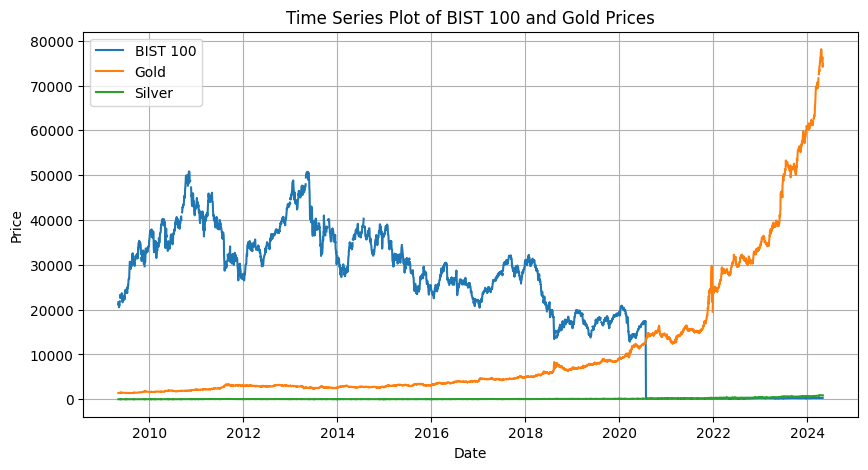

In [187]:
plt.figure(figsize=(10, 5))
plt.plot(prices['BIST100_USD'], label='BIST 100')
plt.plot(prices['Gold'], label='Gold')
plt.plot(prices['Silver'], label='Silver')
plt.title('Time Series Plot of BIST 100 and Gold Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()